# Verification of Quantum Circuits

Compiling quantum algorithms results in different representations of the considered functionality, which significantly differ in their basis operations and structure but are still supposed to be functionally equivalent.
As described in the previous section, even individual compilation tasks can be highly complex.
Consequently, checking whether the original functionality is indeed maintained throughout all these different abstractions becomes increasingly relevant in order to guarantee a consistent and error-free compilation flow.
This is similar to the classical realm, where descriptions at various levels of abstraction also exist.
These descriptions are verified using design automation expertise---resulting in efficient methods for verification to ensure the correctness of the design across different levels of abstraction.
However, since quantum circuits additionally employ quantum-physical effects such as superposition and entanglement, these methods cannot be used out of the box in the quantum realm.
Accordingly, verification of quantum circuits must be approached from a different perspective.
At first glance, these characteristics of quantum computing make verification much harder as for classical circuits and systems.
In fact, equivalence checking of quantum circuits has been proven to be a computationally hard problem.

At the same time, quantum circuits possess certain characteristics that offer remarkable potential for efficient equivalence checking that is not available in classical computing.
More precisely, consider two quantum circuits $G=g_1,\dots,g_m$ and $G'=g'_1,\dots,g'_n$ whose equivalence shall be checked.
Due to the inherent reversibility of quantum operations, the inverse of a quantum circuit can easily be computed by taking the complex conjugate of every gate and reversing the sequence of the gates in the circuit, i.e., $G^{\prime -1}= (g'_n)^\dagger,\dots,(g'_1)^\dagger$.
If two circuits are equivalent, this allows for the conclusion that $G\cdot G^{\prime -1} = I$, where $I$ is the identity function.
Since the identity has the most compact representation for most data structures representing quantum functionality (e.g., linear with respect to the number of qubits in case of decision diagrams), the equivalence check can be simplified considerably.
Even complex circuits can be verified efficiently, if one manages to apply the gates of both circuits in a sequence that keeps the intermediate representation "close to the identity".
Within the MQT, several methods and strategies were proposed that utilize this characteristic of quantum computations.
Eventually, this led to solutions that can verify the results of whole quantum compilation flows (such as IBM's Qiskit) in negligible runtime---something we never even managed for classical circuits and systems.

The _MQT_ offers the quantum circuit equivalence checking tool QCEC which encompasses a comprehensive suite of efficient methods and automated tools for the verification of quantum circuits.
By this, an important step towards avoiding or substantially mitigating the emerge of a verification gap for quantum circuits is taken, i.e., a situation where the physical development of a technology substantially outperforms our ability to design suitable applications for it or to verify it.

Verifying that the quantum circuit from before has been correctly compiled to the shown architecture from i.e., whether it still implements the functionality of the circuit, merely requires the following lines of Python:

In [1]:
from qiskit.providers.fake_provider import Fake5QV1
from mqt.qmap import compile
from mqt.bench import get_benchmark

circ = get_benchmark(benchmark_name="ghz", level="alg", circuit_size=3)
backend = Fake5QV1()
circ_mapped, _ = compile(circ, backend)

## Shown the initial and compiled circuits


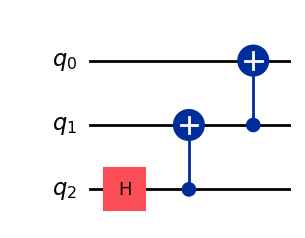

In [2]:
circ.remove_final_measurements()
circ.draw(output='mpl')

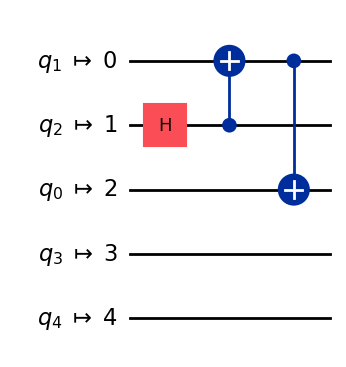

In [3]:
circ_mapped.remove_final_measurements()
circ_mapped.draw(output='mpl')

In [4]:
from qiskit.quantum_info import Operator
op = Operator(circ).to_matrix()
for elem in op:
    print(elem)

[0.70710678+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.70710678+0.j 0.        +0.j 0.        +0.j 0.        +0.j]
[0.        +0.j 0.70710678+0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.70710678+0.j 0.        +0.j 0.        +0.j]
[0.        +0.j 0.        +0.j 0.        +0.j 0.70710678+0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]
[0.        +0.j 0.        +0.j 0.70710678+0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.70710678+0.j 0.        +0.j]
[ 0.        +0.j  0.        +0.j  0.70710678+0.j  0.        +0.j
  0.        +0.j  0.        +0.j -0.70710678+0.j  0.        +0.j]
[ 0.        +0.j  0.        +0.j  0.        +0.j  0.70710678+0.j
  0.        +0.j  0.        +0.j  0.        +0.j -0.70710678+0.j]
[ 0.        +0.j  0.70710678+0.j  0.        +0.j  0.        +0.j
  0.        +0.j -0.70710678+0.j  0.        +0.j  0.        +0.j]
[ 0.70710678+0.j  0.        +0.j  0.        +0.j  0.        +0.j
 -0.70710678+0.j  0.        +0.j  0.        +0.j  

In [5]:
op = Operator(circ_mapped).to_matrix()
for elem in op:
    print(elem)


[0.70710678+0.j 0.        +0.j 0.70710678+0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
[0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.70710678+0.j 0.        +0.j 0.70710678+0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
[ 0.        +0.j  0.70

## Simplified using MQT QCEC

In [6]:
from mqt.qcec import verify

result = verify(circ, circ_mapped)
print(result.equivalence)

equivalent
